In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm
from itertools import product

MHT Tracker

In [2]:
class Track:
    def __init__(self, track_id, bbox):
        self.track_id = track_id
        self.bbox = bbox
        self.age = 0
        self.hits = 1

class MHTTracker:
    def __init__(self, iou_threshold=0.3, max_age=5, min_hits=2):
        self.tracks = []
        self.next_id = 1
        self.iou_threshold = iou_threshold
        self.max_age = max_age
        self.min_hits = min_hits

    def iou(self, boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
        yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = boxA[2] * boxA[3]
        boxBArea = boxB[2] * boxB[3]
        return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

    def update(self, detections):
        assigned_tracks = set()
        assigned_dets = set()

        if len(self.tracks) == 0:
            for det in detections:
                self.tracks.append(Track(self.next_id, det))
                self.next_id += 1
            return self.get_active_tracks()

        cost_matrix = np.zeros((len(self.tracks), len(detections)), dtype=np.float32)
        for i, track in enumerate(self.tracks):
            for j, det in enumerate(detections):
                cost_matrix[i, j] = 1 - self.iou(track.bbox, det)

        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        for r, c in zip(row_ind, col_ind):
            if cost_matrix[r, c] < 1 - self.iou_threshold:
                self.tracks[r].bbox = detections[c]
                self.tracks[r].age = 0
                self.tracks[r].hits += 1
                assigned_tracks.add(r)
                assigned_dets.add(c)

        for i, track in enumerate(self.tracks):
            if i not in assigned_tracks:
                track.age += 1

        self.tracks = [t for t in self.tracks if t.age <= self.max_age]

        for j, det in enumerate(detections):
            if j not in assigned_dets:
                self.tracks.append(Track(self.next_id, det))
                self.next_id += 1

        return self.get_active_tracks()

    def get_active_tracks(self):
        return [t for t in self.tracks if t.hits >= self.min_hits]

Utils

In [3]:
def get_file_lists(folder):
    return sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.json')])

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

def draw_tracks(image, tracks):
    for track in tracks:
        x, y, w, h = track.bbox
        cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
        cv2.putText(image, f'ID:{track.track_id}', (int(x), int(y - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    return image


Evaluation

In [4]:
def evaluate_with_mota(all_gt_boxes, all_pred_boxes, all_pred_ids, iou_threshold=0.5):
    total_tp = total_fp = total_fn = 0
    id_switches = 0
    prev_id_assignments = {}
    
    for frame_idx, (gt_boxes, pred_boxes, pred_ids) in enumerate(zip(all_gt_boxes, all_pred_boxes, all_pred_ids)):
        matched_gt = set()
        matched_pred = set()
        id_assignment = {}

        for i, pred_box in enumerate(pred_boxes):
            best_iou = 0
            best_gt_idx = -1
            for j, gt_box in enumerate(gt_boxes):
                if j in matched_gt:
                    continue
                iou = compute_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = j

            if best_iou >= iou_threshold:
                matched_gt.add(best_gt_idx)
                matched_pred.add(i)
                id_assignment[best_gt_idx] = pred_ids[i]
                if best_gt_idx in prev_id_assignments:
                    if prev_id_assignments[best_gt_idx] != pred_ids[i]:
                        id_switches += 1

        prev_id_assignments = id_assignment.copy()

        tp = len(matched_gt)
        fp = len(pred_boxes) - len(matched_pred)
        fn = len(gt_boxes) - len(matched_gt)

        total_tp += tp
        total_fp += fp
        total_fn += fn

    mota = 1 - (total_fp + total_fn + id_switches) / max(total_tp + total_fn, 1)
    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    return {
        "TP": total_tp,
        "FP": total_fp,
        "FN": total_fn,
        "IDSW": id_switches,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "MOTA": mota
    }


In [6]:
folder = r'C:\Users\PC1\Desktop\2D\X-band'
json_files = get_file_lists(folder)
split_idx = int(len(json_files) * 0.8)
warmup_files = json_files[:split_idx]
test_files = json_files[split_idx:]

best_mota = -1
best_params = {}

param_grid = {
    "iou_threshold": [0.1, 0.3, 0.5, 0.6 ,0.7,0.8],
    "max_age": [3, 5, 7],
    "min_hits": [1, 2, 3]
}

print(" Starting Hyperparameter Search...\n")
for iou_thres, max_age, min_hits in tqdm(product(param_grid['iou_threshold'],
                                                 param_grid['max_age'],
                                                 param_grid['min_hits']),
                                         total=27, ncols=80, ascii=True):
    tracker = MHTTracker(iou_threshold=iou_thres, max_age=max_age, min_hits=min_hits)

    for json_file in warmup_files:
        with open(json_file, 'r') as f:
            data = json.load(f)
        annotations = data.get('annotations', [])
        gt_boxes = [[ann['xmin'], ann['ymin'], ann['width'], ann['height']] for ann in annotations]
        tracker.update(gt_boxes)

    all_gt_boxes = []
    all_pred_boxes = []
    all_pred_ids = []

    for json_file in test_files:
        with open(json_file, 'r') as f:
            data = json.load(f)
        annotations = data.get('annotations', [])
        gt_boxes = [[ann['xmin'], ann['ymin'], ann['width'], ann['height']] for ann in annotations]

        tracks = tracker.update(gt_boxes)
        pred_boxes = [t.bbox for t in tracks]
        pred_ids = [t.track_id for t in tracks]

        all_gt_boxes.append(gt_boxes)
        all_pred_boxes.append(pred_boxes)
        all_pred_ids.append(pred_ids)

    metrics = evaluate_with_mota(all_gt_boxes, all_pred_boxes, all_pred_ids)

    if metrics["MOTA"] > best_mota:
        best_mota = metrics["MOTA"]
        best_params = {
            "iou_threshold": iou_thres,
            "max_age": max_age,
            "min_hits": min_hits,
            "metrics": metrics
        }


print("\n Best Hyperparameters:")
print(f"iou_threshold: {best_params['iou_threshold']}")
print(f"max_age      : {best_params['max_age']}")
print(f"min_hits     : {best_params['min_hits']}")
print(f"MOTA         : {best_params['metrics']['MOTA']:.4f}")
print(f"Precision    : {best_params['metrics']['Precision']:.4f}")
print(f"Recall       : {best_params['metrics']['Recall']:.4f}")
print(f"F1           : {best_params['metrics']['F1']:.4f}")
print(f"TP: {best_params['metrics']['TP']}  FP: {best_params['metrics']['FP']}  FN: {best_params['metrics']['FN']}  IDSW: {best_params['metrics']['IDSW']}")


 Starting Hyperparameter Search...



54it [04:19,  4.81s/it]                                                         


 Best Hyperparameters:
iou_threshold: 0.1
max_age      : 3
min_hits     : 3
MOTA         : 0.0491
Precision    : 0.6558
Recall       : 0.7803
F1           : 0.7126
TP: 1431  FP: 751  FN: 403  IDSW: 590


In [9]:
import cv2
import matplotlib.pyplot as plt

def draw_tracking(image_path, tracks, frame_index):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for track in tracks:
        if hasattr(track, "frames") and frame_index not in track.frames:
            continue
        if track.age > 0 or track.hits < 1:
            continue
        x, y, w, h = map(int, track.bbox)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f'ID:{track.track_id}', (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Tracking Result - Frame {frame_index}")
    plt.show()


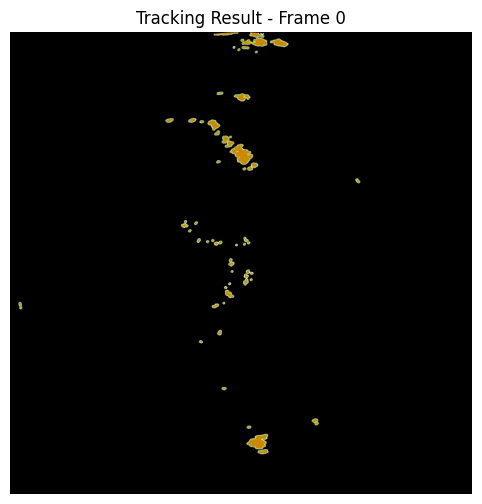

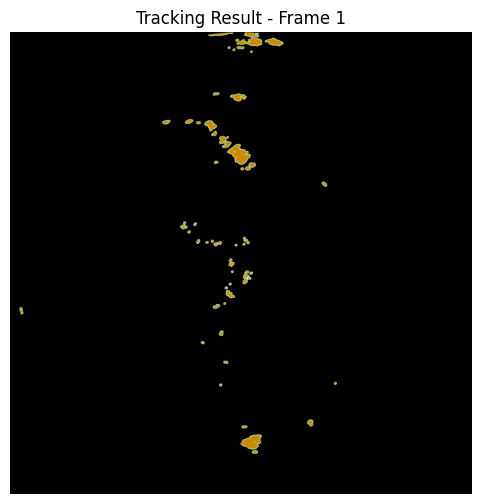

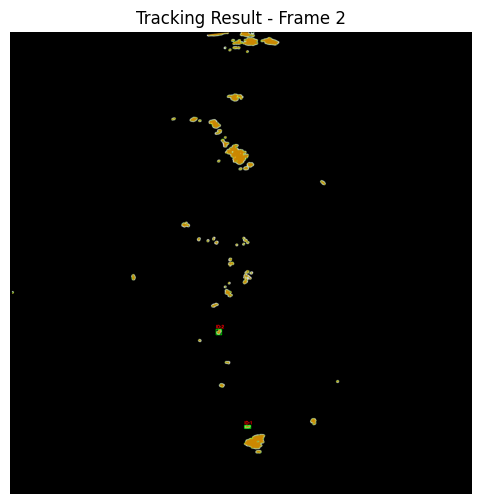

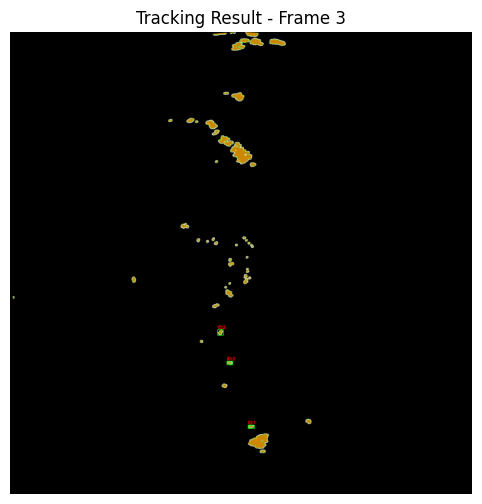

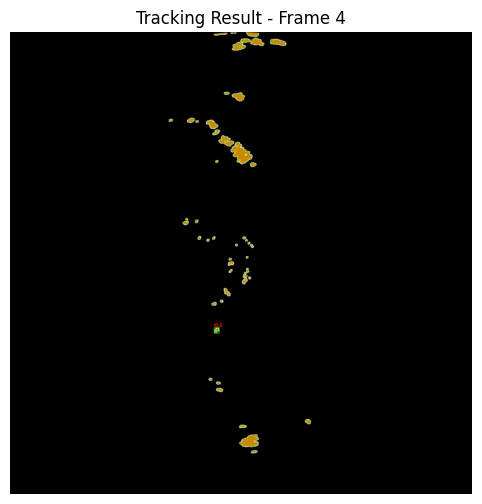

In [11]:
folder = r'C:\Users\PC1\Desktop\2D\X-band'
json_files = get_file_lists(folder)
tracker = MHTTracker(iou_threshold=0.1, max_age=3, min_hits=3)

for frame_idx, json_file in enumerate(json_files[:5]):
    with open(json_file, 'r') as f:
        data = json.load(f)
    annotations = data.get('annotations', [])
    gt_boxes = [[ann['xmin'], ann['ymin'], ann['width'], ann['height']] for ann in annotations]

    tracks = tracker.update(gt_boxes)

    image_path = json_file.replace(".json", ".png")
    draw_tracking(image_path, tracks, frame_idx)
